# DATATHON


### 1. Mounting Google Colab with Drive

In [2]:
# Library for mounting google colab with Drive to access datasets
from google.colab import drive
#Mount drive
drive.mount('/content/drive/',force_remount=True)
# Project path - Main directory where all the files are placed
project_path = "/content/drive/My Drive/"
!ls

Mounted at /content/drive/
drive  sample_data


### 2. Installing necessary libraries


---

*   Keras and using Tensorflow 1.0v


In [3]:
!pip install keras==2.2.5
%tensorflow_version 1.x

  Using cached https://files.pythonhosted.org/packages/f8/ba/2d058dcf1b85b9c212cc58264c98a4a7dd92c989b798823cc5690d062bb2/Keras-2.2.5-py2.py3-none-any.whl
  Found existing installation: Keras 2.1.5
    Uninstalling Keras-2.1.5:
      Successfully uninstalled Keras-2.1.5
TensorFlow 1.x selected.




*   mrcnn



In [4]:
!pip install mrcnn

     |████████████████████████████████| 61kB 8.1MB/s 
  Created wheel for mrcnn: filename=mrcnn-0.2-cp37-none-any.whl size=54930 sha256=004f44dac2f07a28f6538bec86f02d908080e0e4912b05fd31b4dca74ceca001
  Stored in directory: /root/.cache/pip/wheels/11/ed/28/e550ddc897c04c336b923eae4eb35c9aae993d20ce39d9cc40
Successfully built mrcnn


### 3. Importing all necessary Libraries

In [5]:
#Importing all necessary Libraries
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from os import listdir
from xml.etree import ElementTree
from numpy import zeros,asarray,expand_dims,mean
from mrcnn.config import Config
from mrcnn import visualize
from mrcnn.visualize import display_instances
from mrcnn import model as modellib, utils
from mrcnn.utils import Dataset,compute_ap, compute_recall,compute_iou
from mrcnn.model import load_image_gt,mold_image, MaskRCNN

Using TensorFlow backend.


### 4. Setting up path with constants

---

*   Root directory
*   Coco Model directory
*   Path to save trained model



In [6]:
# Root directory of the project
ROOT_DIR = "/content/drive/My Drive"
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

### 5. Setting up custom configuration based on our custom dataset



*   Setting up custom configuration class for defining configuration for training our model




In [7]:
class CustomConfig(Config):
    # Give the configuration a recognizable name
    NAME = "name"
    IMAGES_PER_GPU = 1
    # Number of classes (including background)
    NUM_CLASSES = 2 + 1  # Background + damage + cardboard
    STEPS_PER_EPOCH = 100 # Number of training steps per epoch
    DETECTION_MIN_CONFIDENCE = 0.9  # Skip detections with < 90% confidence



*   Defining a class to load dataset, load mask and set image reference for our dataset



In [8]:
class CustomDataset(utils.Dataset):
  def load_custom(self, dataset_dir, subset):
        # Add classes, we have two classes.
        self.add_class("name", 1, "cardboard")
        self.add_class("name", 2, "damage")

        # Train or validation dataset?
        assert subset in ["train", "valid"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations1.values())
        annotations = [a for a in annotations if a['regions']]
        for a in annotations:
            polygons = [r['shape_attributes'] for r in a['regions'].values()]
            objects = [s['region_attributes']['name'] for s in a['regions'].values()]
            name_dict = {"cardboard": 1,"damage": 2}
            num_ids = [name_dict[a] for a in objects]
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            self.add_image(
                "name", 
                image_id=a['filename'],
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)
  def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "name":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "name":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)

        for i, p in enumerate(info["polygons"]):
          if p['name'] == 'polygon':
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])            
          elif p['name'] == 'rect':
            rr, cc = skimage.draw.rectangle(start=(p['x'], p['y']), end=(p['width'],p['height']))
          rr[rr > mask.shape[0]-1] = mask.shape[0]-1
          cc[cc > mask.shape[1]-1] = mask.shape[1]-1
          mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

  def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "name":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)



*   Function to train our model based on the training and valid dataset



In [9]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom(ROOT_DIR, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom(ROOT_DIR, "valid")
    dataset_val.prepare()
    
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=10,
                layers='heads')


### 6. TRAINING



*   Defining our MRCNN model and training the model based on our custom dataset(Cardboard boxes+damages)


In [10]:
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config,model_dir=DEFAULT_LOGS_DIR)

weights_path =COCO_WEIGHTS_PATH

if not os.path.exists(weights_path):
  utils.download_trained_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead










*   Calling function to train our model



In [ ]:
train(model)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/logs/name20210519T0619/mask_rcnn_name_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDi

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 1/10
100/100 [==============================] - 114s 1s/step - loss: 2.1426 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.6605 - mrcnn_class_loss: 0.2256 - mrcnn_bbox_loss: 0.5926 - mrcnn_mask_loss: 0.6434 - val_loss: 1.7185 - val_rpn_class_loss: 0.0070 - val_rpn_bbox_loss: 0.5612 - val_mrcnn_class_loss: 0.1761 - val_mrcnn_bbox_loss: 0.4356 - val_mrcnn_mask_loss: 0.5386
Epoch 2/10
100/100 [==============================] - 66s 656ms/step - loss: 1.4014 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3587 - mrcnn_class_loss: 0.1506 - mrcnn_bbox_loss: 0.3641 - mrcnn_mask_loss: 0.5159 - val_loss: 1.5448 - val_rpn_class_loss: 0.0076 - val_rpn_bbox_loss: 0.5579 - val_mrcnn_class_loss: 0.1524 - val_mrcnn_bbox_loss: 0.3735 - val_mrcnn_mask_loss: 0.4534
Epoch 3/10
100/100 [==============================] - 66s 656ms/step - loss: 1.0869 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2068 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.2570 - mrcnn_mask_loss: 0.5003 - val_loss: 1.6565 - val_rpn_cla

### 7. Tensorboard

---

Using tensorboard for providing the measurements and visualizations needed during the machine learning workflow

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir "/content/drive/My Drive/logs/"

### 8. Validation


---



*   Defining configuration for predicting values with our validation dataset



In [11]:
config = CustomConfig()
class PredictionConfig(config.__class__):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = 0.7

In [12]:
def get_ax(rows=1, cols=1, size=16):
   _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
   return ax



*   Evaluation Model to determine **Precision, Recall, F1_Score and Accuracy(IoU)**



In [13]:
def evaluate_model(dataset, model, cfg):
  APs = list()
  F1_scores = list()
  ARs=list()
  iou=list()
  for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
    yhat = model.detect([image], verbose=1)
    r = yhat[0]
    # Areas of anchors and GT boxes
    area1 = (r["rois"][:, 2] - r["rois"][:, 0]) * (r["rois"][:, 3] - r["rois"][:, 1])
    area2 = (gt_bbox[:, 2] - gt_bbox[:, 0]) * (gt_bbox[:, 3] - gt_bbox[:, 1])
    # Compute overlaps to generate matrix [r["rois"] count, gt_bbox count]
    # Each cell contains the IoU value.
    overlaps = np.zeros((r["rois"].shape[0], gt_bbox.shape[0]))
    for i in range(overlaps.shape[1]):
        box2 = gt_bbox[i]
        overlaps[:, i] = compute_iou(box2, r["rois"], area2[i], area1)
    iou.append(mean(overlaps))
    AP, precisions, recalls, overlaps = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
    AR, positive_ids = compute_recall(r["rois"], gt_bbox, iou=0.2)
    ARs.append(AR)
    F1_scores.append((2* ((mean(precisions) * mean(recalls))/(mean(precisions) + mean(recalls)))))
    APs.append(AP)
  #Storing the values pf precision, Recall and F1 score in a .csv file
  data={"Image ID":dataset.image_ids,"Precision":APs,"Recall":ARs,"F1 score": F1_scores,"IoU":iou}
  df = pd.DataFrame(data)
  df.to_csv('Data.csv', index=False)
  mAP = mean(APs)
  mAR = mean(ARs)



*   Using model based on our training to predict the value of validation dataset and calculate the Confusion Matrix.



In [14]:
#To test the data for validation
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
test_set =CustomDataset()
test_set.load_custom(ROOT_DIR,"valid")
test_set.prepare()

cfg = PredictionConfig()
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=cfg)
model.load_weights("/content/drive/My Drive/logs/name20210518T1448/mask_rcnn_name_0010.h5", by_name=True)
evaluate_model(test_set, model, cfg)



Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 10
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_i

### 9. TESTING

---
Running the model to predict the damages on cardboard boxes with visualization (testing dataset)



Processing 1 images
image                    shape: (225, 225, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (192, 262, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (191, 264, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.1

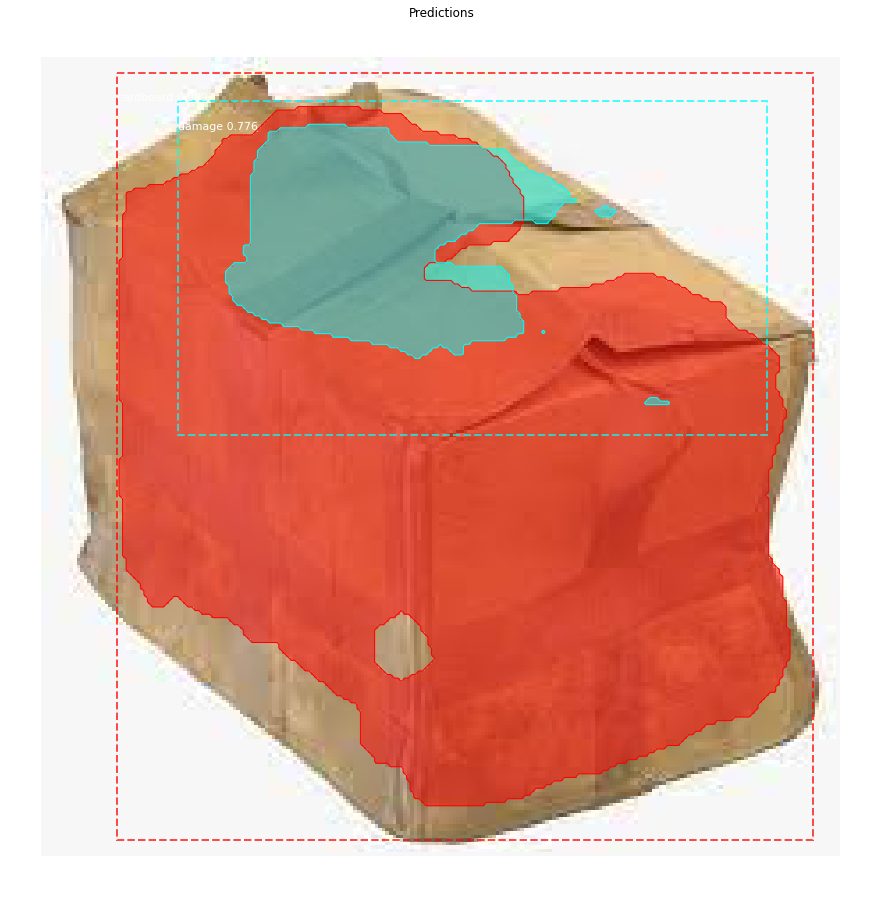

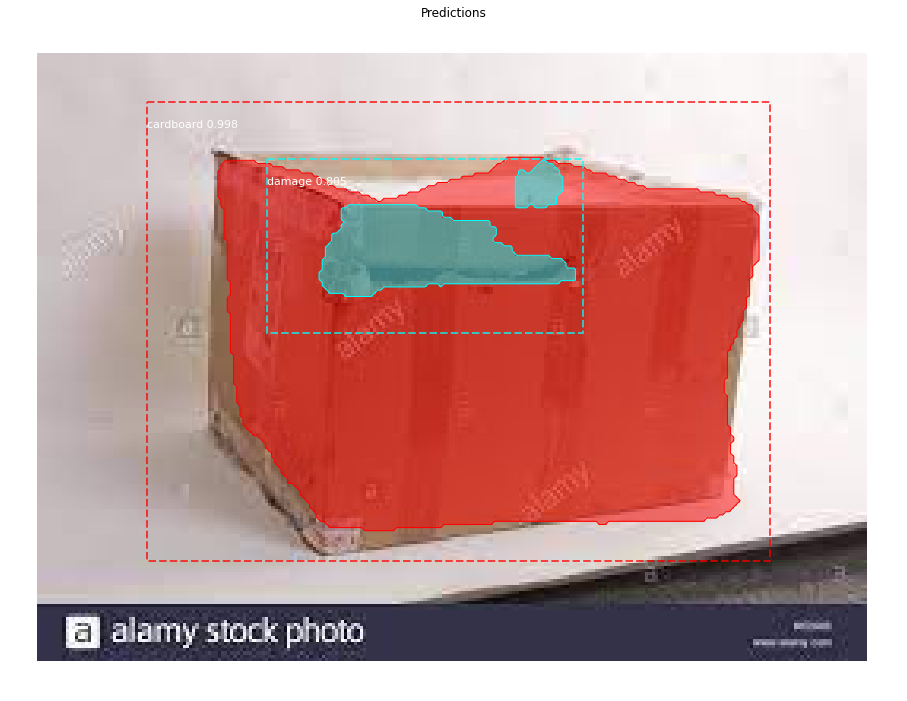

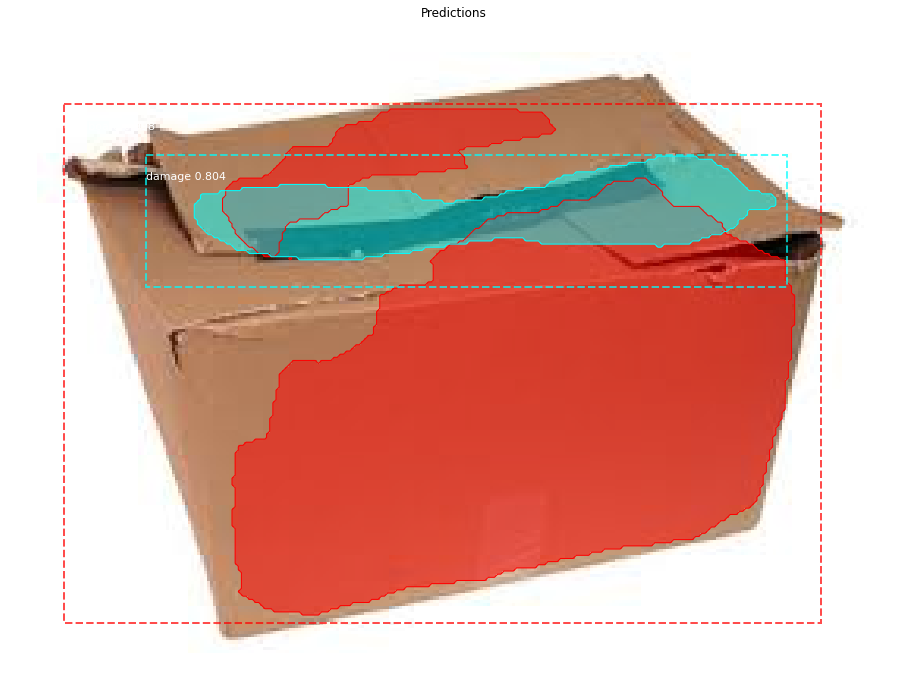

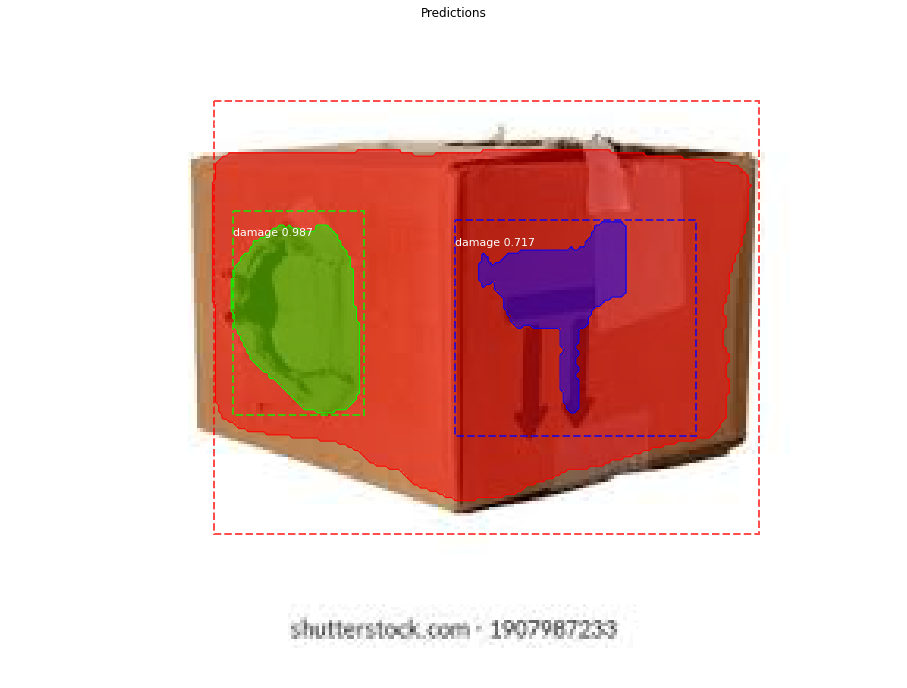

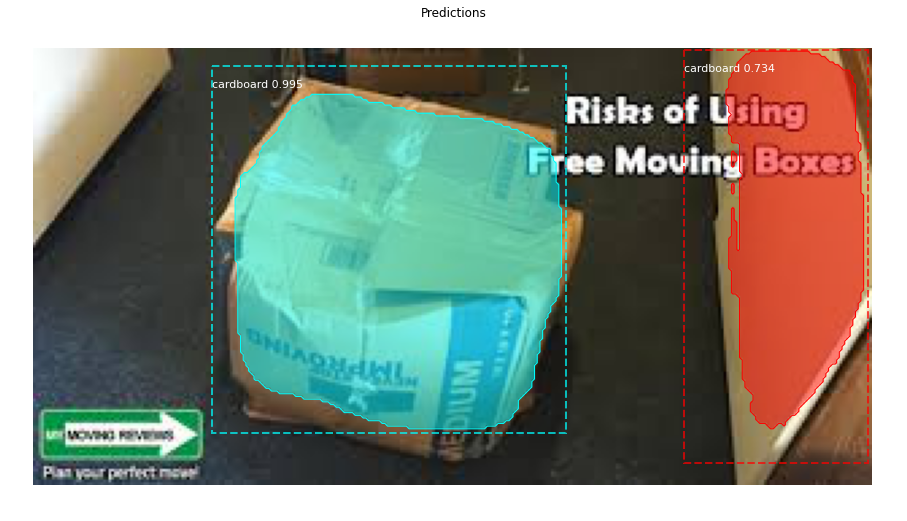

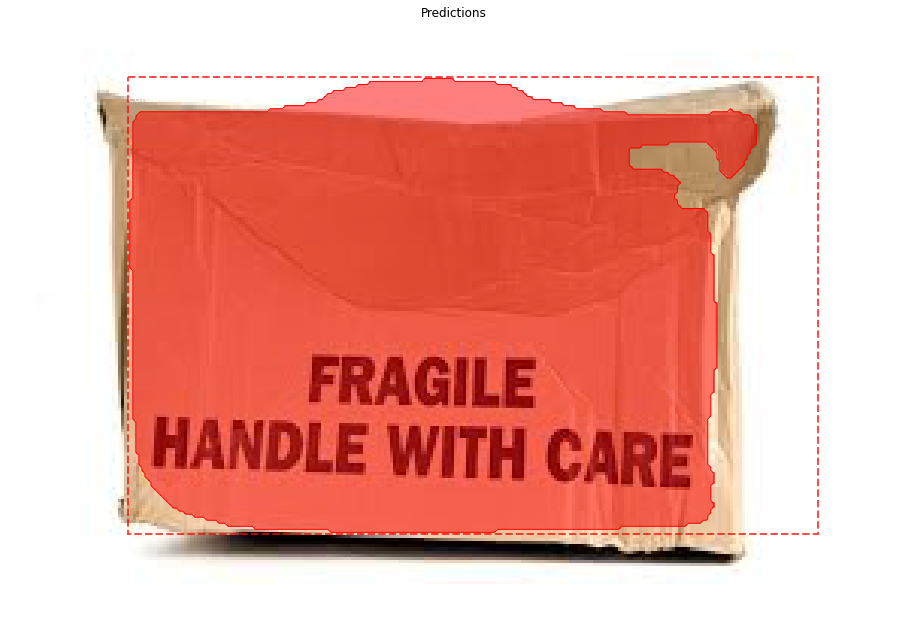

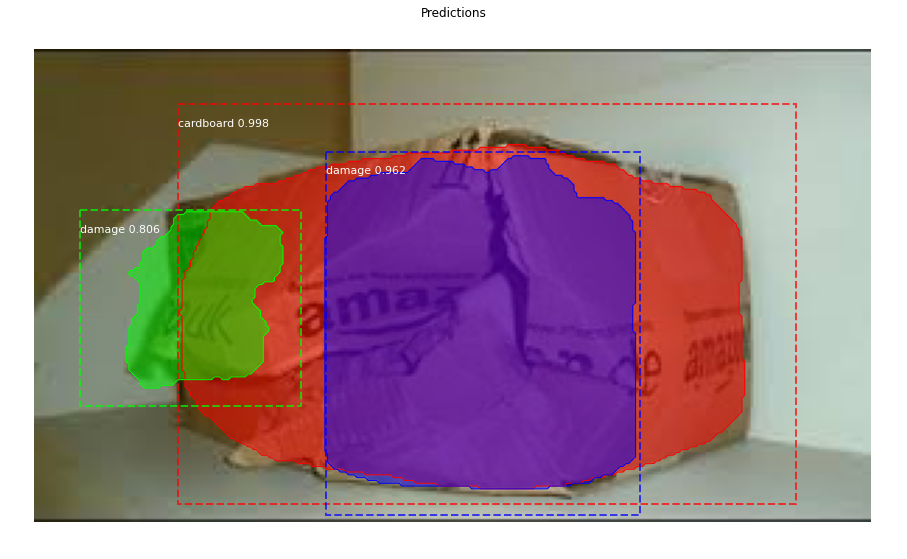

In [15]:
# Predicting on test data
w=[]
h=[]
a=[]
id=[]
for i in range(1,8):
  path_to_new_image = '/content/drive/My Drive/test/'+str(i)+'.jpg'
  id.append(i)
  image = mpimg.imread(path_to_new_image)
  # Run object detection
  results1 = model.detect([image], verbose=1)
  # Display results
  ax = get_ax(1)
  r1 = results1[0]
  width=r1['rois'][0][2]-r1['rois'][0][0]
  w.append(width)
  height=r1['rois'][0][3]-r1['rois'][0][1]
  h.append(height)
  a.append(width*height)
  visualize.display_instances(image, r1['rois'], r1['masks'], r1['class_ids'],test_set.class_names, r1['scores'], ax=ax, title="Predictions")
#Storing dimensions in a .csv file
data={"Image ID":id,"Width":w,"Height":h,"Area": a}
df = pd.DataFrame(data)
df.to_csv('Result_Dimension.csv', index=False)